<a href="https://colab.research.google.com/github/hari4698/WeatherForecasting/blob/master/Best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

url = 'https://raw.githubusercontent.com/MadanAravind/Weather-Forecast-using-NN/master/weather16-18.csv'

In [0]:
features = ["time", "temperature", "humidity", "dewPoint", "pressure", "windSpeed"]
df1 = pd.read_csv(url)
records = df1.values.tolist()

df = pd.DataFrame(records, columns=features).set_index('time') 

In [0]:
X = df[[col for col in df.columns if col != 'temperature']]

y = df['temperature'] 

In [0]:
train_set = df.head(20619)

In [0]:
X_train = train_set[[col for col in train_set.columns if col != 'temperature']]

y_train = train_set['temperature'] 

In [0]:
val_set = df.iloc[20619:23197]

X_val = val_set[[col for col in val_set.columns if col != 'temperature']]
y_val = val_set['temperature']

In [0]:
test_set = df.tail(2577)
X_test = test_set[[col for col in test_set.columns if col != 'temperature']]
y_test = test_set['temperature']

In [0]:
import numpy as np  
import tensorflow as tf  
from sklearn.metrics import explained_variance_score,mean_absolute_error,median_absolute_error
from sklearn.model_selection import train_test_split  

In [30]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   20619, Training features   4
Validation instances 2578, Validation features 4
Testing instances    2577, Testing features    4


In [0]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [34]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc61d52d3c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=200):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [36]:
evaluations = []  
STEPS = 200  
for i in range(100):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-60000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 60000 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 1.3201196, step = 60001
INFO:tensorflow:global_step/sec: 353.493
INFO

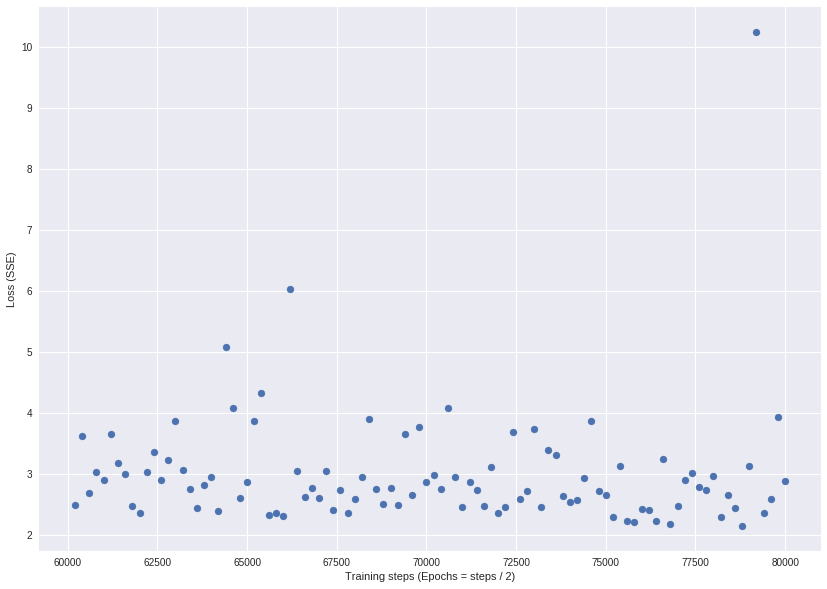

In [37]:
import matplotlib.pyplot as plt  
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps (Epochs = steps / 2)')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [38]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(  
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 1.00
The Mean Absolute Error: 0.07 degrees Celcius
The Median Absolute Error: 0.06 degrees Celcius


In [0]:
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')

In [0]:
y_test.to_csv('test_temperature.csv')